In [5]:
# Cella 1: Environment Setup & Bootstrap Logic

"""
BOOTSTRAP SCRIPT
----------------
This cell acts as the entry point for the runtime environment.
It ensures "Idempotency" (the ability to run the script multiple times without
side effects) by cleaning previous states, and sets up the Python Module Search Path
to allow for absolute imports from the repository root.
"""

import os
import sys

# =============================================================================
# 1. ENVIRONMENT SANITIZATION (Reset)
# =============================================================================
# We force a return to the container root and wipe the existing repository.
# This prevents "State Leakage" where old config files or artifacts from a
# previous run might corrupt the current execution.
print(">>> Executing Environment Reset (Clean Slate)...")
try:
    os.chdir('/content/')
    # Force remove (-rf) to handle non-empty directories and git history without prompts
    !rm -rf Hawk-AI-CV-Project
except Exception as e:
    # Pass silently if directory doesn't exist (first run)
    pass

# =============================================================================
# 2. SOURCE CODE RETRIEVAL (Clone)
# =============================================================================
# Pulling the latest version of the codebase (HEAD) from the remote origin.
!git clone https://github.com/leonardoCosta02/Hawk-AI-CV-Project.git

# =============================================================================
# 3. RUNTIME CONTEXT & PATH CONFIGURATION
# =============================================================================
repo_name = "Hawk-AI-CV-Project"

# Change the working directory of the shell/notebook kernel to the project root.
%cd $repo_name

# CRITICAL: UPDATING PYTHONPATH
# By default, Python looks for modules in site-packages and the script directory.
# We explicitly inject the current working directory (os.getcwd()) to the TOP (index 0)
# of sys.path.
# WHY? This allows us to use absolute imports like `from src import config`
# regardless of which sub-folder we are currently executing code in.
sys.path.insert(0, os.getcwd())

# =============================================================================
# 4. DEPENDENCY RESOLUTION
# =============================================================================
print(">>> Installing Runtime Dependencies...")
# - numpy: Vector math
# - opencv-python: Computer Vision algorithms (Canny, Hough, Homography)
# - matplotlib: Visualization and plotting
!pip install numpy opencv-python matplotlib

# =============================================================================
# 5. VERIFICATION
# =============================================================================
print("\n>>> Setup Complete. Active Runtime Root:")
print(os.getcwd())
# Check if imports work immediately to fail fast if something went wrong
try:
    import numpy as np
    import cv2
    print(f">>> Dependencies verified: OpenCV {cv2.__version__}")
except ImportError as e:
    print(f"!!! CRITICAL ERROR: Dependency installation failed - {e}")

>>> Executing Environment Reset (Clean Slate)...
Cloning into 'Hawk-AI-CV-Project'...
remote: Enumerating objects: 779, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 779 (delta 1), reused 0 (delta 0), pack-reused 775 (from 2)
Receiving objects: 100% (779/779), 56.28 MiB | 30.98 MiB/s, done.
Resolving deltas: 100% (331/331), done.
/content/Hawk-AI-CV-Project
>>> Installing Runtime Dependencies...

>>> Setup Complete. Active Runtime Root:
/content/Hawk-AI-CV-Project
>>> Dependencies verified: OpenCV 4.12.0


In [6]:
# Cella 1.5: Module Cache Purge (Hot Reload Strategy)

"""
HOT RELOAD MECHANISM
--------------------
In persistent kernels (like Jupyter/Colab), Python optimizes performance by
caching imported modules in `sys.modules`.

If you modify the source code of `config.py` on disk and re-run a cell with
`import src.config`, Python will silently ignore the file changes and serve
the old version from RAM.

This script manually evicts specific modules from the runtime cache to force
a fresh read from the filesystem during the next execution.
"""

import importlib
import sys

# =============================================================================
# CACHE EVICTION LOGIC
# =============================================================================

# 1. Evict Configuration Module
# Critical when tuning hyperparameters (e.g., changing Hough thresholds).
# We check if the key exists to avoid a KeyError on the first run.
if 'src.config' in sys.modules:
    del sys.modules['src.config']  # Hard delete from the singleton dictionary

# 2. Evict Feature Extraction Module
# Critical when debugging Canny/Hough algorithms.
if 'src.court_features' in sys.modules:
    del sys.modules['src.court_features']

# Note: We do not typically evict 'cv2' or 'numpy' as they are static libraries
# and re-importing them is computationally expensive and unnecessary.

print(">>> RUNTIME STATUS: Stale modules purged from RAM.")
print(">>> ACTION: Cell 2 will now load the latest code from disk.")

>>> RUNTIME STATUS: Stale modules purged from RAM.
>>> ACTION: Cell 2 will now load the latest code from disk.


In [7]:
# Cella 2: Data Ingestion & Preprocessing

"""
DATA INGESTION LAYER
--------------------
This cell is responsible for loading the raw static assets into memory.
It handles the "Color Space Impedance Mismatch" between OpenCV and Matplotlib:
- OpenCV reads images as BGR (Blue-Green-Red).
- Matplotlib displays images as RGB (Red-Green-Blue).

We store both versions to ensure compatibility with both processing algorithms (M1)
and visualization tools.
"""

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from src import config

# Global Registry to hold loaded datasets in memory
# Structure: { 'SURFACE_NAME': { 'bgr': np.array, 'rgb': np.array, 'path': str } }
immagini_caricate = {}

print("========================================================")
print("== INITIATING STATIC ASSET LOADER (FROM CONFIG) ==")
print("========================================================")

# Iterate through the surface configuration defined in config.py
for superficie, params in config.ALL_SURFACE_PARAMS.items():

    image_path = params['FRAME_PATH']

    # 1. LOAD RAW ASSET
    # cv.imread loads the image into a Numpy array.
    # Native Format: BGR (Standard for legacy camera hardware compatibility)
    bgr_image = cv.imread(image_path)

    if bgr_image is not None:
        # 2. COLOR SPACE CONVERSION
        # Essential for human-readable visualization later.
        # Without this, red tennis courts would appear blue.
        rgb_image = cv.cvtColor(bgr_image, cv.COLOR_BGR2RGB)

        # 3. STORE IN MEMORY
        # We keep the BGR version for processing (algorithms expect it)
        # and the RGB version for debugging/plotting.
        immagini_caricate[superficie] = {
            'bgr': bgr_image,  # Input for Feature Extraction (M1)
            'rgb': rgb_image,  # Input for Visualization (Matplotlib)
            'path': image_path,
        }

        # Log success with dimensions (Height, Width, Channels)
        h, w, c = bgr_image.shape
        print(f"✅ Asset Loaded: {superficie} | Resolution: {w}x{h} px | Channels: {c}")
    else:
        # Error handling for missing files or broken paths
        print(f"❌ FATAL ERROR: Could not load asset for {superficie} at path: {image_path}")

print("========================================================")

== INITIATING STATIC ASSET LOADER (FROM CONFIG) ==
✅ Asset Loaded: CEMENTO | Resolution: 1075x613 px | Channels: 3
✅ Asset Loaded: ERBA | Resolution: 1068x609 px | Channels: 3
✅ Asset Loaded: TERRA_BATTUTA | Resolution: 1069x601 px | Channels: 3



== PROCESSING TARGET: CEMENTO ==
   [Telemetry] CANNY: 15 / 120
   [Telemetry] HOUGH THRESHOLD: 60
=== DEBUG: M1 — SPATIAL FILTERS ===
Post-ROI Filter count: 25
=== DEBUG: M1 — ORIENTATION SPLIT ===
Horizontal: 17  Vertical: 8
=== DEBUG: M1 — MERGE RESULTS ===
Merged H: 3  Merged V: 3

✅ [DEBUG M3] Sample Vector Output (First 5 lines):
[[184 401 695 402]
 [342 315 744 314]
 [328 199 745 198]
 [672 150 780 405]
 [306 399 407 151]]
   Tensor Shape: (6, 4)


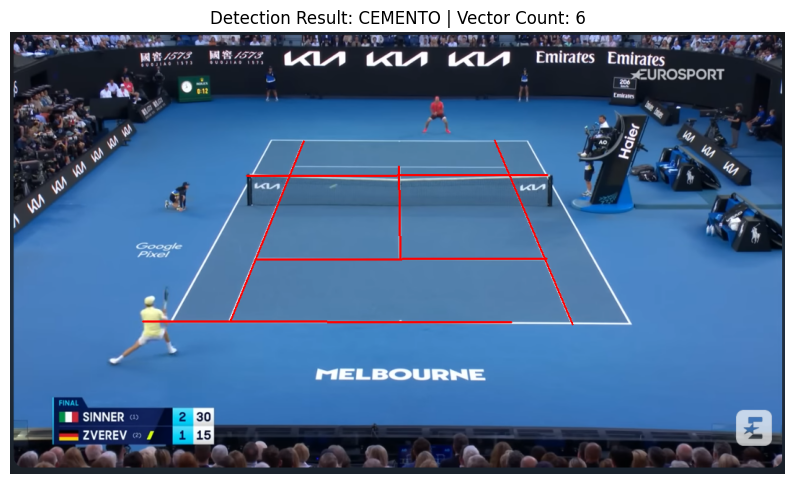


== PROCESSING TARGET: ERBA ==
   [Telemetry] CANNY: 15 / 150
   [Telemetry] HOUGH THRESHOLD: 65
=== DEBUG: M1 — SPATIAL FILTERS ===
Post-ROI Filter count: 38
=== DEBUG: M1 — ORIENTATION SPLIT ===
Horizontal: 28  Vertical: 10
=== DEBUG: M1 — MERGE RESULTS ===
Merged H: 5  Merged V: 3


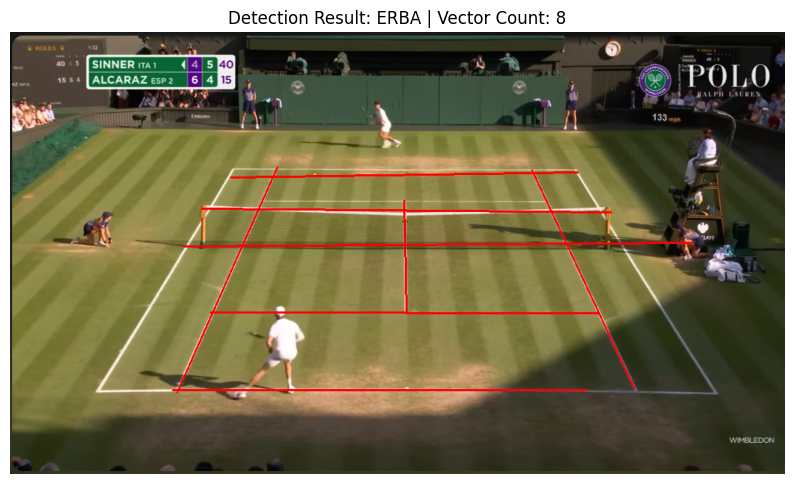


== PROCESSING TARGET: TERRA_BATTUTA ==
   [Telemetry] CANNY: 40 / 150
   [Telemetry] HOUGH THRESHOLD: 60
=== DEBUG: M1 — SPATIAL FILTERS ===
Post-ROI Filter count: 25
=== DEBUG: M1 — ORIENTATION SPLIT ===
Horizontal: 19  Vertical: 6
=== DEBUG: M1 — MERGE RESULTS ===
Merged H: 4  Merged V: 3


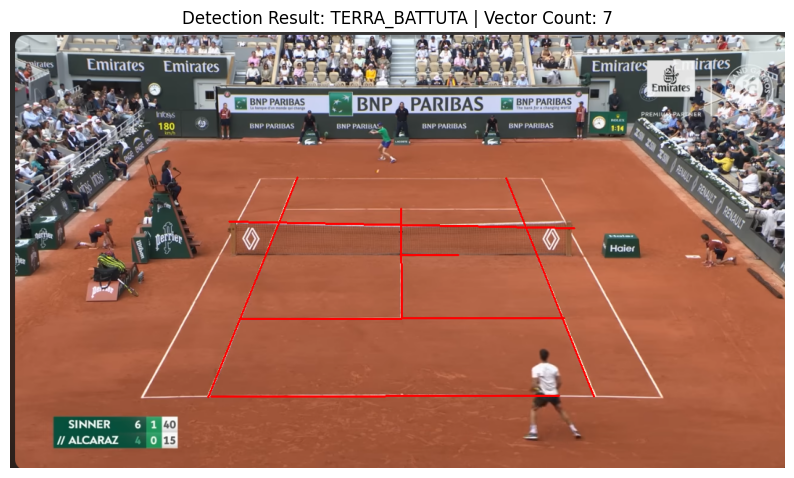


======================= EXECUTION SUMMARY =======================

SURFACE: CEMENTO
   -> Detected Vectors: 6
   -> Parameters (High/Hough): 120/60

SURFACE: ERBA
   -> Detected Vectors: 8
   -> Parameters (High/Hough): 150/65

SURFACE: TERRA_BATTUTA
   -> Detected Vectors: 7
   -> Parameters (High/Hough): 150/60


In [8]:
# Cella 3: Batch Execution & Visual Verification Loop

"""
PIPELINE EXECUTION & VISUALIZATION
----------------------------------
This cell orchestrates the feature extraction process across all loaded datasets.
It serves three main purposes:
1. Batch Processing: Iterates through each surface type (Hard, Grass, Clay).
2. Visual Sanity Check: Overlays detected Hough lines onto the original frames to
   verify hyperparameter tuning.
3. Data Serialization: Packages the raw line segments and images into a structured
   dictionary ('risultati_finali') for the Homography Module (Cell 4).
"""

from src.court_features import trova_linee  # Core logic import
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

# Container for downstream processing (Homography)
risultati_finali = {}

# =============================================================================
# 1. BATCH PROCESSING LOOP
# =============================================================================
# Iterate through the dictionary of loaded images from the previous cell.
for superficie, dati_immagine in immagini_caricate.items():

    # Retrieve surface-specific hyperparameters from config (Dynamic Injection)
    params = config.ALL_SURFACE_PARAMS[superficie]

    print(f"\n========================================================")
    print(f"== PROCESSING TARGET: {superficie} ==")
    print(f"   [Telemetry] CANNY: {params['CANNY_LOW']} / {params['CANNY_HIGH']}")
    print(f"   [Telemetry] HOUGH THRESHOLD: {params['HOUGH_THRESHOLD']}")
    print(f"========================================================")

    # --- FEATURE EXTRACTION ---
    # Call the M1 module to get vector coordinates of the court lines.
    # We pass the 'bgr' version as OpenCV functions expect BGR input.
    raw_line_segments = trova_linee(dati_immagine['bgr'], superficie)

    # --- INTEGRATION DEBUG (Handshake with M3) ---
    # This block verifies that the output tensor shape is correct for the
    # colleague working on the Homography matrix (M3).
    if superficie == 'CEMENTO':
        print(f"\n✅ [DEBUG M3] Sample Vector Output (First 5 lines):")
        print(raw_line_segments[:5])
        print(f"   Tensor Shape: {raw_line_segments.shape}") # Expecting (N, 4)
    # -----------------------------------------------

    # =========================================================================
    # 2. VISUALIZATION PIPELINE (Overlay Logic)
    # =========================================================================
    # We work on a copy to maintain data immutability of the source image.
    line_frame_rgb = np.copy(dati_immagine['rgb'])
    linee_trovate = len(raw_line_segments)

    if linee_trovate > 0:
        # COLOR SPACE SWITCH: RGB -> BGR
        # OpenCV drawing functions (cv.line) operate in BGR space.
        line_frame_bgr = cv.cvtColor(line_frame_rgb, cv.COLOR_RGB2BGR)

        # Draw vector overlays
        for x1, y1, x2, y2 in raw_line_segments:
            # Color: (0, 0, 255) = Red in BGR. Thickness: 2px.
            cv.line(line_frame_bgr, (x1, y1), (x2, y2), (0, 0, 255), 2)

        # COLOR SPACE SWITCH: BGR -> RGB
        # Matplotlib expects RGB for correct rendering.
        line_frame_rgb = cv.cvtColor(line_frame_bgr, cv.COLOR_BGR2RGB)


    # Rendering via Matplotlib
    plt.figure(figsize=(10, 8))
    plt.imshow(line_frame_rgb)
    plt.title(f"Detection Result: {superficie} | Vector Count: {linee_trovate}")
    plt.axis('off')
    plt.show()

    # =========================================================================
    # 3. DATA PERSISTENCE
    # =========================================================================
    # Save the processed data into a structured payload.
    # This dictionary effectively acts as the API response for the next cell.
    risultati_finali[superficie] = {
        'Canny Low': params['CANNY_LOW'],
        'Canny High': params['CANNY_HIGH'],
        'Hough Threshold': params['HOUGH_THRESHOLD'],
        'Totale Linee Trovate': linee_trovate,
        'Raw Segments': raw_line_segments,    # Key input for Homography
        'Original Image': dati_immagine['rgb'] # Ground truth for checking alignment
    }

# =============================================================================
# 4. EXECUTIVE SUMMARY
# =============================================================================
print("\n======================= EXECUTION SUMMARY =======================")
for superficie, res in risultati_finali.items():
    print(f"\nSURFACE: {superficie}")
    print(f"   -> Detected Vectors: {res['Totale Linee Trovate']}")
    print(f"   -> Parameters (High/Hough): {res['Canny High']}/{res['Hough Threshold']}")

🏁 STARTING HOMOGRAPHY ESTIMATION (MATRIX H)

--- 🗺️ CALIBRATING SURFACE: CEMENTO ---
Input Data: 6 raw segments.


🏁 HOMOGRAPHY CALCULATION START: CEMENTO

[DEBUG] Input Segments: 6
[WARN] Histogram unreliable. Fallback to longest segment: 0.11°
[DEBUG] FINAL ANGLES -> theta_h: 0.11°, theta_v: 90.11°
[DEBUG] Classified Horizontal: 3
[DEBUG] Classified Vertical: 3

[DEBUG] --- TEMPLATE FITTING ---

[DEBUG] Semantic Lines Identified:
  Base      : [184. 401. 695. 402.]
  Service   : [342. 315. 744. 314.]
  Left Side : [306. 399. 407. 151.]
  Right Side: [672. 150. 780. 405.]

[DEBUG] --- INTERSECTION COMPUTATION ---
  p1 (BL): (np.float64(305.08897807283824), np.float64(401.2369647320408))
  p2 (BR): (np.float64(778.7988663333257), np.float64(402.1639899536856))
  p3 (TL): (np.float64(340.20786184045386), np.float64(315.0044580551232))
  p4 (TR): (np.float64(741.46149798281), np.float64(314.0063146816348))

=== HOMOGRAPHY MATRIX COMPUTED SUCCESSFULLY ===
[[ 6.50980565e-02  2.65116930e-02

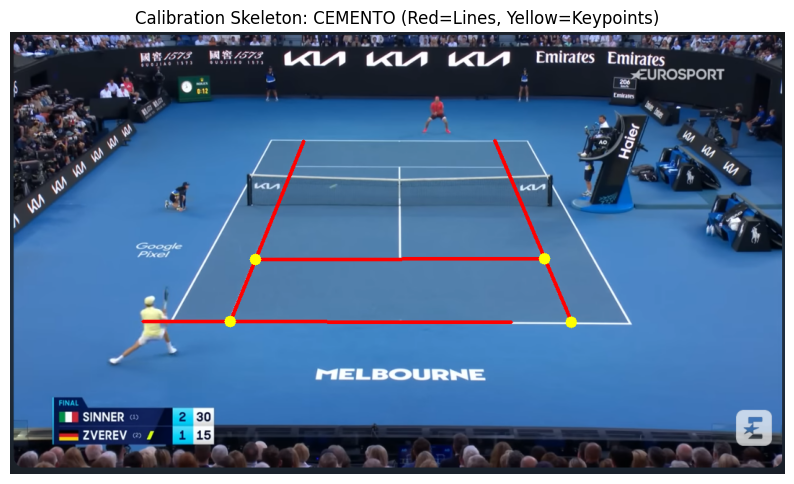


--- REPROJECTION TEST (Sanity Check) ---
Input Pixel (Image Space): (0, 0) (u, v)
Projected Point (World Space): X=-30.498m, Y=92.296m

--- 🗺️ CALIBRATING SURFACE: ERBA ---
Input Data: 8 raw segments.


🏁 HOMOGRAPHY CALCULATION START: ERBA

[DEBUG] Input Segments: 8
[WARN] Histogram unreliable. Fallback to longest segment: 179.59°
[DEBUG] FINAL ANGLES -> theta_h: 179.59°, theta_v: 89.59°
[DEBUG] Classified Horizontal: 5
[DEBUG] Classified Vertical: 3

[DEBUG] --- TEMPLATE FITTING ---

[DEBUG] Semantic Lines Identified:
  Base      : [224. 493. 795. 493.]
  Service   : [276. 386. 810. 387.]
  Left Side : [230. 496. 368. 186.]
  Right Side: [719. 190. 860. 491.]

[DEBUG] --- INTERSECTION COMPUTATION ---
  p1 (BL): (np.float64(231.33548387096775), np.float64(493.0))
  p2 (BR): (np.float64(860.9368770764119), np.float64(493.0))
  p3 (TL): (np.float64(278.9652699815304), np.float64(386.00555294004033))
  p4 (TR): (np.float64(811.2835179615549), np.float64(387.0024035916883))

=== HOMOGRAPH

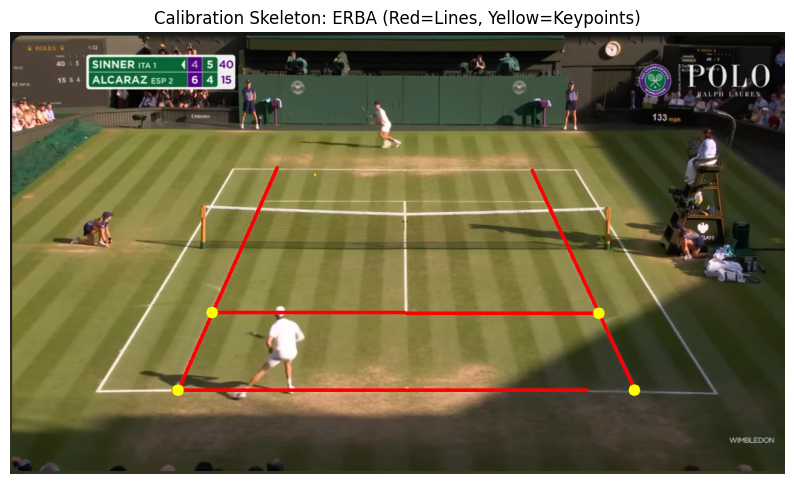


--- REPROJECTION TEST (Sanity Check) ---
Input Pixel (Image Space): (0, 0) (u, v)
Projected Point (World Space): X=-19.924m, Y=85.165m

--- 🗺️ CALIBRATING SURFACE: TERRA_BATTUTA ---
Input Data: 7 raw segments.


🏁 HOMOGRAPHY CALCULATION START: TERRA_BATTUTA

[DEBUG] Input Segments: 7
[WARN] Histogram unreliable. Fallback to longest segment: 179.88°
[DEBUG] FINAL ANGLES -> theta_h: 179.88°, theta_v: 89.88°
[DEBUG] Classified Horizontal: 4
[DEBUG] Classified Vertical: 3

[DEBUG] --- TEMPLATE FITTING ---

[DEBUG] Semantic Lines Identified:
  Base      : [277. 502. 757. 501.]
  Service   : [316. 395. 764. 394.]
  Left Side : [273. 503. 396. 200.]
  Right Side: [684. 201. 805. 502.]

[DEBUG] --- INTERSECTION COMPUTATION ---
  p1 (BL): (np.float64(273.40289849088543), np.float64(502.00749396147734))
  p2 (BR): (np.float64(804.5581773293408), np.float64(500.9009204638972))
  p3 (TL): (np.float64(316.8423474240715), np.float64(394.99811976021414))
  p4 (TR): (np.float64(761.5868829138542), np

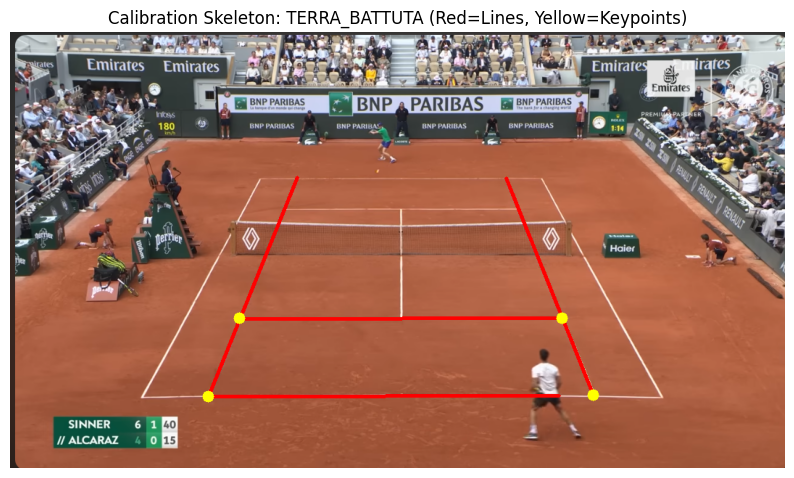


--- REPROJECTION TEST (Sanity Check) ---
Input Pixel (Image Space): (0, 0) (u, v)
Projected Point (World Space): X=-31.531m, Y=107.257m

✨ PIPELINE COMPLETE: Generated 3 Calibration Matrices.


In [9]:
# Cella 4: Homography Estimation (M3) & Model Validation

"""
HOMOGRAPHY SOLVER & CALIBRATION
-------------------------------
This cell computes the 3x3 Homography Matrix (H) for each surface.
It bridges the gap between the 2D Image Plane (pixels) and the 3D World Plane (meters).

Process:
1. Input: Raw line segments from Cell 3.
2. Logic: The 'homography_calculator' selects the 4 structural lines (Baseline, Service, Sides).
3. Output: The Matrix H and the 4 detected corners.
4. Validation: Visualizes the "Anchor Skeleton" (Red Lines + Yellow Corners) to verify alignment.
"""

from src import homography_calculator
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np

# Registry to store the computed matrices for the final application
homography_matrices = {}

# Unit Test Coordinate (Top-Left of the image)
# We will use this to check if the matrix projection is numerically stable.
test_pixel_coords = (0,0)

print("======================================================")
print("🏁 STARTING HOMOGRAPHY ESTIMATION (MATRIX H)")
print("======================================================")

# Iterate through the processed data from the Feature Extraction stage (Cell 3)
for superficie, risultati in risultati_finali.items():

    # --- DATA RETRIEVAL ---
    # Retrieve the candidate line segments detected by the Hough Transform
    line_segments_m1 = risultati['Raw Segments']

    # Copy the ground truth image for visualization (non-destructive)
    original_image_rgb = risultati['Original Image'].copy()

    # Convert to BGR for OpenCV drawing functions
    original_image_bgr = cv.cvtColor(original_image_rgb, cv.COLOR_RGB2BGR)

    print(f"\n--- 🗺️ CALIBRATING SURFACE: {superficie} ---")

    # Safety Check: Early exit if feature extraction failed
    if line_segments_m1.size == 0:
        print("❌ CRITICAL: No segments available. Skipping calibration.")
        continue

    print(f"Input Data: {line_segments_m1.shape[0]} raw segments.")

    # =========================================================================
    # 1. COMPUTE HOMOGRAPHY MATRIX (H)
    # =========================================================================
    # This function is the core of Module 3. It:
    # A. Identifies the 4 Semantic Lines (Base, Service, Left, Right).
    # B. Computes their intersections (The 4 Keypoints).
    # C. Solves the linear system to find H.
    H_matrix, selected_lines, intersection_points = homography_calculator.calculate_homography(
        line_segments_m1, superficie
    )

    if H_matrix is not None:
        # Register the successful matrix
        homography_matrices[superficie] = H_matrix

        print(f"\n✅ Matrix H computed successfully for {superficie}.")
        print("Matrix H (3x3):")
        print(H_matrix)

        # =====================================================================
        # 2. VISUAL VALIDATION (Anchor Skeleton)
        # =====================================================================
        img_display = original_image_bgr.copy()

        # Overlay the 4 Semantic Lines (RED)
        # These represent the "Geometric Constraints" of our model.
        for x1, y1, x2, y2 in selected_lines:
            cv.line(img_display, (x1, y1), (x2, y2), (0, 0, 255), 4)

        # Overlay the 4 Computed Intersections (YELLOW)
        # These are the source points (src_pts) used in cv.findHomography
        for px, py in intersection_points:
            if px is not None and py is not None:
                cv.circle(img_display, (int(px), int(py)), 8, (0, 255, 255), -1)

        # Render the Validation Frame
        plt.figure(figsize=(10, 8))
        plt.imshow(cv.cvtColor(img_display, cv.COLOR_BGR2RGB))
        plt.title(f"Calibration Skeleton: {superficie} (Red=Lines, Yellow=Keypoints)")
        plt.axis('off')
        plt.show()

        # =====================================================================
        # 3. PROJECTION SANITY CHECK
        # =====================================================================
        # We project a test pixel (0,0) into World Space (Meters).
        # If this returns NaN or Inf, the matrix is singular/degenerate.
        world_coords = homography_calculator.map_pixel_to_world(H_matrix, test_pixel_coords)

        print("\n--- REPROJECTION TEST (Sanity Check) ---")
        print(f"Input Pixel (Image Space): {test_pixel_coords} (u, v)")
        print(f"Projected Point (World Space): X={world_coords[0]:.3f}m, Y={world_coords[1]:.3f}m")

    else:
        print(f"❌ HOMOGRAPHY FAILED for {superficie}. Check intersection logic or segment quality.")

print("\n======================================================")
print(f"✨ PIPELINE COMPLETE: Generated {len(homography_matrices)} Calibration Matrices.")
print("======================================================")

In [10]:
# Validation Script: Homography Accuracy Assessment

"""
UNIT TEST: HOMOGRAPHY REPROJECTION ERROR
----------------------------------------
This script quantitatively validates the computed Homography Matrix (H).

Methodology:
1. Ground Truth comparison: We take specific pixel coordinates (src) and map them
   to World Space using H.
2. Residual Calculation: We compare the projected World coordinates against the
   Expected World coordinates (defined in config.py).
3. Metric: The differences (Delta X, Delta Y) represent the 'Reprojection Error'.
   Lower values (close to 0.0) indicate a high-quality calibration.
"""

import numpy as np
from src import homography_calculator
from src import config

# Retrieve the calibration matrix for the Hard Court (Baseline test case)
H_matrix = homography_matrices['CEMENTO']

# =============================================================================
# 1. INPUT DATA (Test Vectors)
# =============================================================================
# Hardcoded pixel coordinates representing the 4 key corners of the service box.
# In a fully automated pipeline, these would be the 'intersection_points'
# returned dynamically by Cell 4.
pixel_corners = [
    (305, 401),  # Bottom-Left (Baseline-Side intersection) -> Point 1
    (779, 402),  # Bottom-Right -> Point 2
    (340, 315),  # Top-Left (Net-Side) -> Point 3
    (741, 314),  # Top-Right (Net-Side) -> Point 4
]

# The corresponding "Ground Truth" in Metric Space (from ITF standards)
expected_world = config.POINTS_WORLD_METERS

# =============================================================================
# 2. VALIDATION LOOP
# =============================================================================
print("=== HOMOGRAPHY ACCURACY REPORT ===")
print(f"{'Point':<6} | {'Pixel Input':<15} | {'Projected (m)':<20} | {'Expected (m)':<20} | {'Error (Δ)':<15}")
print("-" * 85)

for i, (px, py) in enumerate(pixel_corners):
    # TRANSFORM: Map 2D Pixel (u,v) -> 3D World (X,Y)
    # This applies the perspective transformation: X = (h11*u + h12*v + h13) / w
    X, Y = homography_calculator.map_pixel_to_world(H_matrix, (px, py))

    # RETRIEVE TRUTH
    X_exp, Y_exp = expected_world[i]

    # CALCULATE RESIDUALS (Error)
    # Ideally, these should be < 0.05 meters (5cm) for tennis analytics.
    diff_X = X - X_exp
    diff_Y = Y - Y_exp

    # LOGGING
    print(f"Pt {i+1:<3} | ({px:3d},{py:3d})       → X={X:6.3f}, Y={Y:6.3f} | X={X_exp:6.3f}, Y={Y_exp:6.3f} | ΔX={diff_X:6.3f}, ΔY={diff_Y:6.3f}")

# Technical Note:
# If ΔX or ΔY are large (> 0.2m), it usually implies:
# 1. The input pixel corners were imprecise (manual selection error).
# 2. The Homography calculation was ill-conditioned (points were collinear).
# 3. The coordinate order in 'pixel_corners' did not match 'expected_world'.

=== HOMOGRAPHY ACCURACY REPORT ===
Point  | Pixel Input     | Projected (m)        | Expected (m)         | Error (Δ)      
-------------------------------------------------------------------------------------
Pt 1   | (305,401)       → X=-0.003, Y= 0.015 | X= 0.000, Y= 0.000 | ΔX=-0.003, ΔY= 0.015
Pt 2   | (779,402)       → X= 8.235, Y= 0.010 | X= 8.230, Y= 0.000 | ΔX= 0.005, ΔY= 0.010
Pt 3   | (340,315)       → X=-0.004, Y= 6.400 | X= 0.000, Y= 6.400 | ΔX=-0.004, ΔY= 0.000
Pt 4   | (741,314)       → X= 8.221, Y= 6.401 | X= 8.230, Y= 6.400 | ΔX=-0.009, ΔY= 0.001
